## Step 2: Scouting Research Candidates

Decision whether or not to pursue a research item

In [ ]:
import sys
sys.path.append('../')

import asyncio
import nest_asyncio
nest_asyncio.apply()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from components.agents.scout_agent import scout_batch

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

Load Research Items

In [2]:
df = pd.read_csv("../data/research_items.csv")

provider_counts = df['provider'].value_counts()
logger.info("Absolute counts:")
logger.info(provider_counts)
logger.info("\nNormalized (proportions):")
logger.info(df['provider'].value_counts(normalize=True))

INFO:__main__:Absolute counts:
INFO:__main__:provider
arxiv        4044
openai        649
anthropic     509
exa           393
Name: count, dtype: int64
INFO:__main__:
Normalized (proportions):
INFO:__main__:provider
arxiv        0.722788
openai       0.115996
anthropic    0.090974
exa          0.070241
Name: proportion, dtype: float64


Select items that have not yet been looked at

In [3]:
pending = df[df["scout_decision"].isna() | df["scout_reasoning"].str.startswith("ERROR:", na=False)]

# Collect scout items
items_to_scout = pending.to_dict("records")
logger.info(f"Number of items to scout: {len(items_to_scout)}")

INFO:__main__:Number of items to scout: 1


Run Scouting

In [ ]:
decisions = asyncio.run(scout_batch(
    items=items_to_scout, 
    batch_size=250
))

INFO:components.agents.scout_agent:Processing batch 1/1 (1 items)
Scout batch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 400 Bad Request"
ERROR:openai.agents:Error getting response: Error code: 400 - {'error': {'message': "Invalid prompt: we've limited access to this content for safety reasons. This type of information may be used to benefit or to harm people. We are continuously refining our work in this area, and you can read more about our approach in our blog post (https://openai.com/index/preparing-for-future-ai-capabilities-in-biology) and Model Spec (https://openai.com/index/introducing-the-model-spec).", 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_prompt'}}. (request_id: req_822e28cd786e4960afcaaa928b8c0f7b)
Scout batch 1/1: 100%|██████████| 1/1 [00:13<00:00, 13.45s/it]


Update DataFrame

In [5]:
for i, (idx, row) in enumerate(pending.iterrows()):
    df.loc[idx, "scout_decision"] = "pursue" if decisions[i].pursue else "discard"
    df.loc[idx, "scout_confidence"] = decisions[i].confidence
    df.loc[idx, "scout_reasoning"] = decisions[i].reasoning
    df.loc[idx, "scouted_at"] = datetime.now().isoformat()

In [6]:
df['scout_decision'].value_counts(dropna=False)

scout_decision
pursue     3280
discard    2315
Name: count, dtype: int64

Save back to DF

In [7]:
df.to_csv("../data/research_items.csv", index=False)

Check some pursue vs discard items

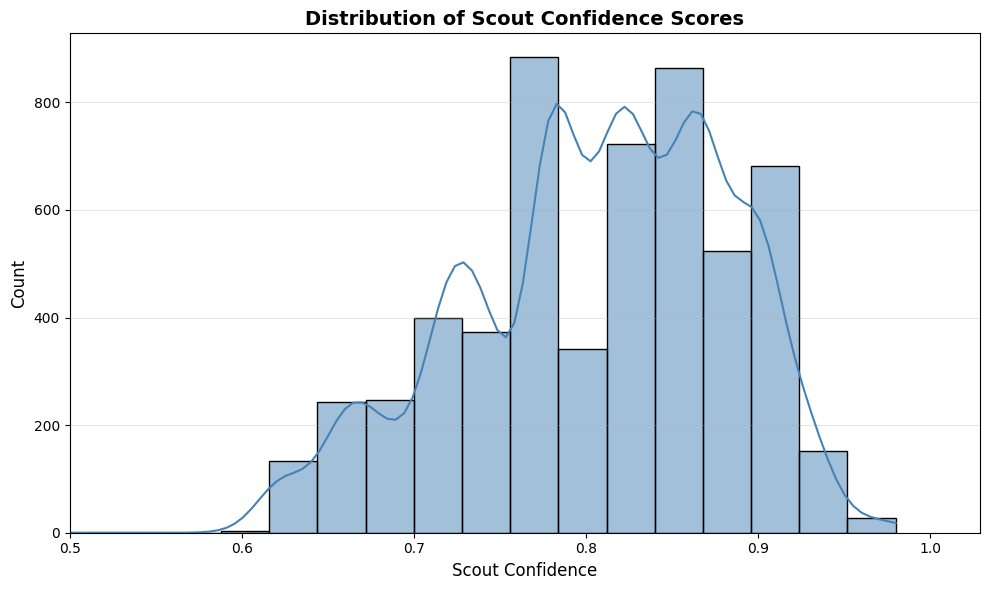

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['scout_confidence'], bins=35, kde=True, ax=ax, color='steelblue')
ax.set_xlabel('Scout Confidence', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Scout Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlim(left=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()